In [25]:
import pickle, gzip
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

from distance import SquaredL2, L2
from neighborhood import neighbor_graph, laplacian
from correspondence import Correspondence
from stiefel import *
from kmedoids import *
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_default_tensor_type('torch.FloatTensor')

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import pdb

In [2]:
f = gzip.open('data/mnist/mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

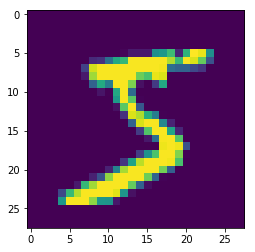

In [3]:
train_set_rs = np.reshape(train_set[0], (50000, 28, 28))
img = train_set_rs[0,:,:]
plt.imshow(img)

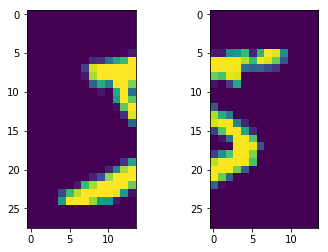

In [4]:
train_label = train_set[1][0:10000]

# Split each image into two halves
train_set_left = train_set_rs[0:10000,:,0:14]
train_set_right = train_set_rs[0:10000,:,14:]

n_train = train_set_left.shape[0]

plt.subplot(1,2,1)
img = train_set_left[0,:,:]
plt.imshow(img)
plt.subplot(1,2,2)
img = train_set_right[0,:,:]
plt.imshow(img)

In [5]:
train_set_left = np.reshape(train_set_left, (n_train, 14*28))
train_set_right = np.reshape(train_set_right, (n_train, 14*28))

In [6]:
print(train_set_left.shape)
print(train_set_right.shape)

(10000, 392)
(10000, 392)


In [7]:
"""Defines the neural network"""
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H1)
        self.linear2 = torch.nn.Linear(H1, H2)
        self.linear3 = torch.nn.Linear(H2, D_out)

    def forward(self, x):
        h1_sigmoid = self.linear1(x).sigmoid()
        h2_sigmoid = self.linear2(h1_sigmoid).sigmoid()
        y_pred = self.linear3(h2_sigmoid)
        return y_pred

In [8]:
def train_and_project(x1_np, x2_np):
    #import pdb
    #pdb.set_trace()
    N, D_in1, D_in2, H1, H2, D_out = x1_np.shape[0], x1_np.shape[1], x2_np.shape[1], 512, 256, 3

    model1 = Net(D_in1, H1, H2, D_out)
    model2 = Net(D_in2, H1, H2, D_out)

    x1 = torch.from_numpy(x1_np.astype(np.float32))
    x2 = torch.from_numpy(x2_np.astype(np.float32))
    print(x1.dtype)
    #%store x1
    #%store x2
    
    #pdb.set_trace()
    
    adj1 = neighbor_graph(x1_np, k=5)
    adj2 = neighbor_graph(x2_np, k=5)

    corr = Correspondence(matrix=np.eye(N))
    
    w = np.block([[corr.matrix(),adj1],
              [adj2, corr.matrix()]])

    L_np, D_np = laplacian(w, normed=True, return_diag=True)
    L = torch.from_numpy(L_np.astype(np.float32))
    
    params = list(model1.parameters()) + list(model2.parameters())
    optimizer = torch.optim.Adam(params, lr = 0.00001)
    
    for t in range(200):
        # Forward pass: Compute predicted y by passing x to the model
        y1_pred = model1(x1)
        y2_pred = model2(x2)

        outputs = torch.cat((y1_pred, y2_pred), 0)

        # Project the output onto Stiefel Manifold
        u, s, v = torch.svd(outputs, some=True)
        proj_outputs = u@v.t()

        # Compute and print loss
        loss = torch.trace(proj_outputs.t()@L@proj_outputs)
        if (t % 2 == 1):
            print(t, loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        proj_outputs.retain_grad()

        optimizer.zero_grad()
        loss.backward(retain_graph=True)

        # Project the (Euclidean) gradient onto the tangent space of Stiefel Manifold (to get Rimannian gradient)
        rgrad = proj_stiefel(proj_outputs, proj_outputs.grad)
        grd = torch.norm(rgrad)
        if (t % 2 == 1):
            print(torch.norm(rgrad))

        optimizer.zero_grad()
        # Backpropogate the Rimannian gradient w.r.t proj_outputs
        proj_outputs.backward(rgrad)

        optimizer.step()
        
    proj_outputs_np = proj_outputs.detach().numpy()
    return proj_outputs_np
    

In [9]:
projections = train_and_project(train_set_left, train_set_right)


torch.float32
1 2.9800167083740234
tensor(1.4705, grad_fn=<NormBackward0>)
3 2.8732478618621826
tensor(1.4771, grad_fn=<NormBackward0>)
5 2.776060104370117
tensor(1.4663, grad_fn=<NormBackward0>)
7 2.692843437194824
tensor(1.4440, grad_fn=<NormBackward0>)
9 2.6239545345306396
tensor(1.4160, grad_fn=<NormBackward0>)
11 2.567401885986328
tensor(1.3860, grad_fn=<NormBackward0>)
13 2.5206124782562256
tensor(1.3560, grad_fn=<NormBackward0>)
15 2.4813618659973145
tensor(1.3267, grad_fn=<NormBackward0>)
17 2.447942018508911
tensor(1.2987, grad_fn=<NormBackward0>)
19 2.419044017791748
tensor(1.2717, grad_fn=<NormBackward0>)
21 2.393662452697754
tensor(1.2457, grad_fn=<NormBackward0>)
23 2.3710646629333496
tensor(1.2202, grad_fn=<NormBackward0>)
25 2.3507590293884277
tensor(1.1952, grad_fn=<NormBackward0>)
27 2.3324501514434814
tensor(1.1708, grad_fn=<NormBackward0>)
29 2.3159544467926025
tensor(1.1473, grad_fn=<NormBackward0>)
31 2.301154613494873
tensor(1.1250, grad_fn=<NormBackward0>)
33 2.2

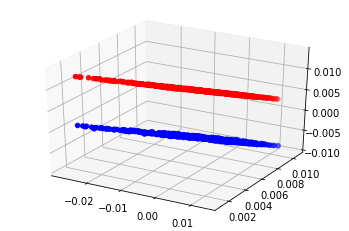

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(projections[0:1000,0],projections[0:1000,1], projections[0:1000,2], color='r')
ax.scatter(projections[10000:11000,0],projections[10000:11000,1], projections[10000:11000,2], color='b')

In [22]:
projections[10000:10100,:]

array([[-4.92857117e-03,  7.06438860e-03, -5.22912387e-03],
       [-1.71457361e-02,  4.46996745e-03, -2.44429056e-03],
       [-2.17904366e-04,  8.43742117e-03, -6.57239696e-03],
       [ 8.00152484e-04,  8.21551494e-03, -6.59706490e-03],
       [ 5.02154604e-03,  9.13021248e-03, -7.53740175e-03],
       [-7.66164484e-03,  6.58277655e-03, -4.65891324e-03],
       [ 6.44644070e-03,  9.51084495e-03, -7.90898968e-03],
       [-1.25187067e-02,  5.55485394e-03, -3.62540642e-03],
       [ 9.57869273e-03,  1.01387510e-02, -8.51417892e-03],
       [-2.14876072e-03,  8.04699957e-03, -6.16245857e-03],
       [-1.94022420e-03,  7.63240829e-03, -5.94787812e-03],
       [-9.16939462e-04,  7.98627455e-03, -6.25155354e-03],
       [-1.87274872e-03,  7.97264092e-03, -6.23260392e-03],
       [-2.53685191e-03,  7.88229331e-03, -5.91660431e-03],
       [ 1.03998696e-02,  1.02300635e-02, -8.69916286e-03],
       [-3.29446769e-03,  7.60627631e-03, -5.72825270e-03],
       [-5.84075600e-03,  7.23010488e-03

In [32]:
x1 = projections[0:10000,:]
x2 = projections[10000:,:]
cov12 = np.cov(x1.T,x2.T)
cov11 = np.cov(x1.T)
cov22 = np.cov(x2.T)

In [37]:
print(np.trace(np.dot(x1.T, x2))/ (np.linalg.norm(x1, ord='fro')*np.linalg.norm(x2, ord='fro')))

0.3107734
